In [ ]:
install.packages("lme4", dependencies=TRUE)
install.packages("simr", dependencies=TRUE)

library(dplyr)
library(ggplot2)
library(lme4)
library(readr)
library(simr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘interp’, ‘future.apply’, ‘latticeExtra’, ‘RcppArmadillo’, ‘quantreg’, ‘phylolm’, ‘ape’, ‘phyr’, ‘gsl’, ‘nonnest2’, ‘sandwich’, ‘lavaan’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘MEMSS’, ‘mlmRev’, ‘optimx’, ‘gamm4’, ‘pbkrtest’, ‘car’, ‘dfoptim’, ‘statmod’, ‘rr2’, ‘semEff’, ‘merDeriv’


Warning message in install.packages("lme4", dependencies = TRUE):
“installation of package ‘gsl’ had non-zero exit status”
Warning message in install.packages("lme4", dependencies = TRUE):
“installation of package ‘semEff’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘binom’, ‘iterators’, ‘plotrix’, ‘plyr’, ‘RLRsim’, ‘lmerTest’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    inter

In [ ]:
##########################################
# Data loading and organization
##########################################

urlfile="https://raw.githubusercontent.com/haiqin-zhang/GestaltICaccents/main/IC_regression.csv"



df <- read_csv(url(urlfile))

df$accent <- factor(df$accent)
df$musician <- factor(df$musician)
df$accent <- relevel(df$accent, ref = "0")
df$musician <- relevel(df$musician, ref = "1")

df$interaction<-contrasts(df$accent)[df$accent]*contrasts(df$musician)[df$musician]

head(df)

## Estimating power using the existing data

In [ ]:
fixed <- high_IC_chosen ~ accent + musician + interaction + (1 | subject)

# Assuming no additional residual structure specified
res <- ~ 1

# Creating the model
model <- lmer(fixed, data = df,
              control = lmerControl(optimizer = "bobyqa"),
              verbose = FALSE)


In [ ]:
sim_treat <- powerSim(model, nsim=100, test = fcompare(high_IC_chosen ~ accent + musician + (1|subject)))
#sim_treat <- powerSim(model, nsim=25, test = fcompare(high_IC_chosen ~ accent + musician + interaction))
sim_treat

## Extending the data to find a suitable sample size

In [ ]:
model_ext_subj <- extend(model, within="accent+musician+subject", n=200)
model_ext_subj

Calculating power at 6 sample sizes within accent+musician+subject



Simulating: |                                                                  |Simulating: |=                                                                 |Simulating: |==                                                                |Simulating: |===                                                               |Simulating: |====                                                              |Simulating: |=====                                                             |

Warning message in observedPowerWarning(sim):
“This appears to be an "observed power" calculation”


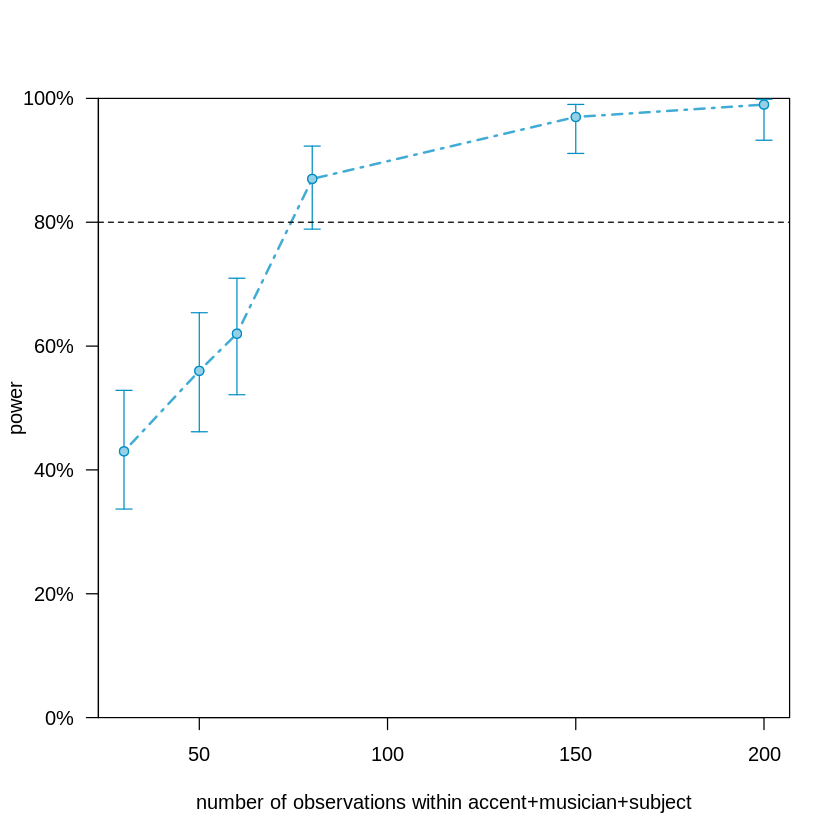

In [ ]:
p_curve_treat <- powerCurve(model_ext_subj,
                test=fcompare(high_IC_chosen ~ accent + musician +(1|subject)),
                within="subject",
                nsim = 100,
                breaks=c(30, 50, 60,  80, 150, 200),
                )
plot(p_curve_treat)

## Model code below (EC)

In [ ]:
## Estimating power using the existing data



fixed <- high_IC_chosen ~ accent + musician + interaction + (1 | subject)



# Creating the model

model <- glmer(fixed, data = df,

              family="binomial",

              verbose = FALSE)



# Extending the data to find a suitable sample size



model_ext_subj1 <- extend(model, along="subject", n=300)

p_curve_treat1 <- powerCurve(model_ext_subj1,

                test = fcompare(high_IC_chosen ~ musician + (1 |subject)),

                within = "accent+musician",

                nsim = 100,

                breaks=c(50, 100, 200, 300),

                )

plot(p_curve_treat1)



`summarise()` has grouped output by 'accent'. You can override using the
`.groups` argument.


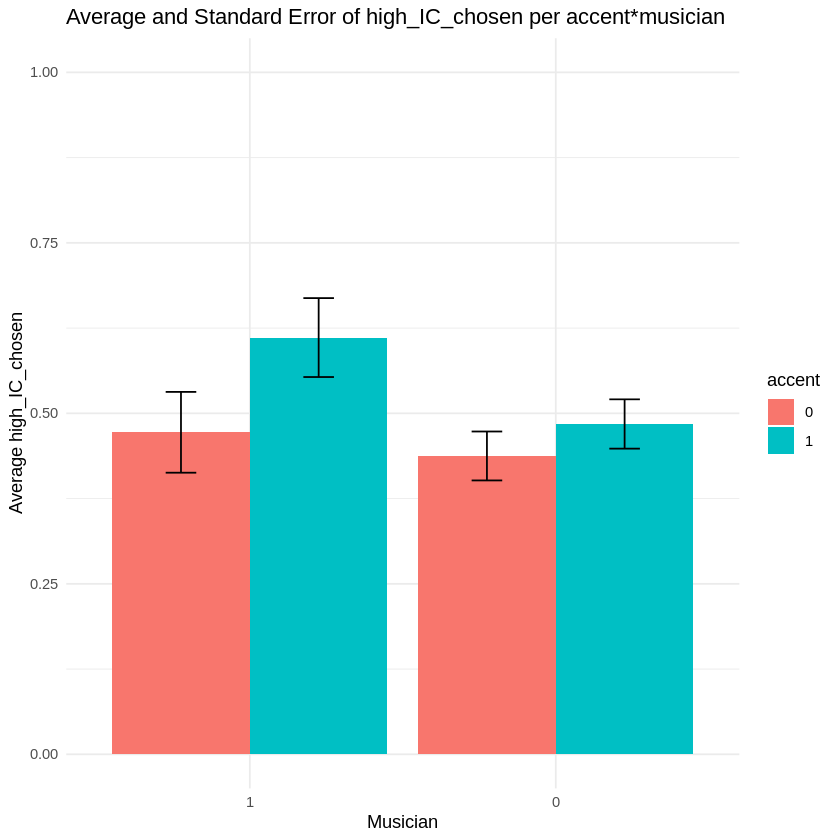

In [ ]:
##########################################
# Plot the data (aggregating per subject)
##########################################
avg_var_df <- df %>%

  group_by(accent, musician) %>%

  summarise(avg_high_IC_chosen = mean(high_IC_chosen, na.rm = TRUE),

            se_high_IC_chosen = sd(high_IC_chosen, na.rm = TRUE)/sqrt(n()))



ggplot(

	avg_var_df,

	aes(x = musician, y = avg_high_IC_chosen, fill = accent)) +

  geom_bar(stat = "identity", position = "dodge") +

  geom_errorbar(aes(ymin = avg_high_IC_chosen - se_high_IC_chosen,

                    ymax = avg_high_IC_chosen + se_high_IC_chosen),

                width = 0.2, position = position_dodge(0.9)) +

  labs(title = "Average and Standard Error of high_IC_chosen per accent*musician",

       x = "Musician", y = "Average high_IC_chosen") +

  theme_minimal() +

  ylim(0,1)

In [ ]:
##########################################
# Analyze effect of accent with random effect per subject
##########################################



model.target <- glmer(

	high_IC_chosen ~ accent+musician+interaction + (1 | subject),

	data=df,

	family="binomial"

)

summary(model.target)

# Marginal effect of accent in the musicians: z=1.690, p=0.091

# Absence of an interaction effect: z=-0.961, p=0.336

#                   Estimate Std. Error z value Pr(>|z|)

# (Intercept)        -0.1144     0.2652  -0.432    0.666

# accent1             0.5796     0.3430   1.690    0.091 .

# musician0          -0.1443     0.3114  -0.464    0.643

# accent1:musician0  -0.3854     0.4010  -0.961    0.336



# The main effect is better analyzed by model comparison: showing that model.target (which has the accent factor), is superior to model.ref (which does not have the accent factor):

model.ref <- update(model.target, ~ . - accent)

anova(model.target, model.ref)

# Marginal main effect of accent, X2(1)=2.8873, p=0.08928

#              npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)

# model.ref       4 733.40 750.48 -362.70   725.40

# model.target    5 732.51 753.86 -361.26   722.51 2.8873  1    0.08928 .


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: high_IC_chosen ~ accent + musician + interaction + (1 | subject)
   Data: df

     AIC      BIC   logLik deviance df.resid 
   732.5    753.9   -361.3    722.5      523 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4422 -0.9188 -0.7681  1.0067  1.4120 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.1166   0.3414  
Number of obs: 528, groups:  subject, 33

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -0.1144     0.2652  -0.432    0.666  
accent1       0.5796     0.3430   1.690    0.091 .
musician0    -0.1443     0.3114  -0.464    0.643  
interaction  -0.3854     0.4010  -0.961    0.336  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) accnt1 muscn0
accent1     -0.631              
musician0   -0.852  0.537

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model.ref,4,733.4021,750.4785,-362.7010,725.4021,NA,NA,NA
model.target,5,732.5148,753.8602,-361.2574,722.5148,2.887315,1,0.08927959


In [ ]:
##########################################

# Analyze effect of accent

# with random effect per sequence

##########################################



model.target <- glmer(

	high_IC_chosen ~ accent+musician+interaction + (1 | sequence),

	data=df,

	family="binomial"

)

summary(model.target)

# Marginal effect of accent in the musicians: z= 1.554, p=0.120

# Absence of an interaction effect: z=-0.881, p= 0.378

#             Estimate Std. Error z value Pr(>|z|)

# (Intercept)  -0.1303     0.2584  -0.504    0.614

# accent1       0.5320     0.3423   1.554    0.120

# musician0    -0.1797     0.2807  -0.640    0.522

# interaction  -0.3510     0.3982  -0.881    0.378



# The main effect is better analyzed by model comparison: showing that model.target (which has the accent factor), is superior to model.ref (which does not have the accent factor):

model.ref <- update(model.target, ~ . - accent)

anova(model.target, model.ref)

# Marginal main effect of accent, X2(1)= 2.4325, p= 0.1188

#              npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)

# model.ref       4 733.64 750.72 -362.82   725.64

# model.target    5 733.21 754.55 -361.60   723.21 2.4325  1     0.1188

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: high_IC_chosen ~ accent + musician + interaction + (1 | sequence)
   Data: df

     AIC      BIC   logLik deviance df.resid 
   733.2    754.6   -361.6    723.2      523 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3369 -0.9366 -0.7709  0.9887  1.2972 

Random effects:
 Groups   Name        Variance Std.Dev.
 sequence (Intercept) 0.05814  0.2411  
Number of obs: 528, groups:  sequence, 8

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.1303     0.2584  -0.504    0.614
accent1       0.5320     0.3423   1.554    0.120
musician0    -0.1797     0.2807  -0.640    0.522
interaction  -0.3510     0.3982  -0.881    0.378

Correlation of Fixed Effects:
            (Intr) accnt1 muscn0
accent1     -0.630              
musician0   -0.774  0.595       
interaction  0.547 -0.852 -0.702

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model.ref,4,733.6392,750.7156,-362.8196,725.6392,NA,NA,NA
model.target,5,733.2068,754.5523,-361.6034,723.2068,2.432451,1,0.1188469


In [ ]:
##########################################
# Analyze effect of accent

# with random effect per subject AND per sequence
##########################################



model.target <- glmer(

	high_IC_chosen ~ accent+musician+interaction + (1 | subject) + (1 | sequence),

	data=df,

	family="binomial"

)

summary(model.target)

# Marginal effect of accent in the musicians: z= 1.568, p= 0.117

# [This is the effect in musicians because musician=1 is taken as reference, see above]

# Absence of an interaction effect: z=-0.890, p= 0.373

#             Estimate Std. Error z value Pr(>|z|)

# (Intercept)  -0.1351     0.2945  -0.459    0.646

# accent1       0.5467     0.3487   1.568    0.117

# musician0    -0.1901     0.3199  -0.594    0.552

# interaction  -0.3607     0.4052  -0.890    0.373



# The main effect is better analyzed by model comparison: showing that model.target (which has the accent factor), is superior to model.ref (which does not have the accent factor):

model.ref <- update(model.target, ~ . - accent)

anova(model.target, model.ref)

# Marginal main effect of accent, X2(1)= 2.4755, p= 0.1156

#              npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)

# model.ref       5 732.67 754.02 -361.34   722.67

# model.target    6 732.20 757.81 -360.10   720.20 2.4755  1     0.1156

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: high_IC_chosen ~ accent + musician + interaction + (1 | subject) +  
    (1 | sequence)
   Data: df

     AIC      BIC   logLik deviance df.resid 
   732.2    757.8   -360.1    720.2      522 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5355 -0.9133 -0.6845  0.9838  1.5215 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.13535  0.3679  
 sequence (Intercept) 0.07545  0.2747  
Number of obs: 528, groups:  subject, 33; sequence, 8

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.1351     0.2945  -0.459    0.646
accent1       0.5467     0.3487   1.568    0.117
musician0    -0.1901     0.3199  -0.594    0.552
interaction  -0.3607     0.4052  -0.890    0.373

Correlation of Fixed Effects:
            (Intr) accnt1 muscn0
accent1     -0.562              
musician0   -0.779  0.53

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model.ref,5,732.6706,754.0161,-361.3353,722.6706,NA,NA,NA
model.target,6,732.1952,757.8097,-360.0976,720.1952,2.475481,1,0.115634


In [ ]:

##########################################
# Analyze effect of interaction with random effect per subject
##########################################



model.target <- glmer(

	high_IC_chosen ~ accent*musician + (1 | subject),

	data=df,

	family="binomial"

)



model.ref <- update(model.target,

	~ . - accent:musician,

)



anova(model.target, model.ref)

# A model comparison confirms that there is no effect of interaction, X2(1)= 0.9277, p= 0.3355

#              npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)

# model.ref       4 731.44 748.52 -361.72   723.44

# model.target    5 732.51 753.86 -361.26   722.51 0.9277  1     0.3355


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model.ref,4,731.4424,748.5188,-361.7212,723.4424,NA,NA,NA
model.target,5,732.5148,753.8602,-361.2574,722.5148,0.9276512,1,0.335474


In [ ]:
##########################################
# Analyze effect of interaction with random effect per sequence

##########################################



model.target <- glmer(

	high_IC_chosen ~ accent*musician + (1 | sequence),

	data=df,

	family="binomial"

)



model.ref <- update(model.target,

	~ . - accent:musician,

)



anova(model.target, model.ref)

# A model comparison confirms that there is no effect of interaction, X2(3)= 0.7791, p= 0.3774

#              npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)

# model.ref       4 731.99 749.06 -361.99   723.99

# model.target    5 733.21 754.55 -361.60   723.21 0.7791  1     0.3774

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model.ref,4,731.9858,749.0622,-361.9929,723.9858,NA,NA,NA
model.target,5,733.2068,754.5523,-361.6034,723.2068,0.7790554,1,0.3774302


In [ ]:

##########################################
# Analyze effect of interaction with random effect per subject AND per sequence

##########################################



model.target <- glmer(

	high_IC_chosen ~ accent*musician + (1 | subject) + (1 | sequence),

	data=df,

	family="binomial"

)



model.ref <- update(model.target,

	~ . - accent:musician,

)



anova(model.target, model.ref)

# A model comparison confirms that there is no effect of interaction, X2(1)= 0.7946, p= 0.3727

#              npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)

# model.ref       5 730.99 752.34 -360.49   720.99

# model.target    6 732.20 757.81 -360.10   720.20 0.7946  1     0.3727

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model.ref,5,730.9897,752.3352,-360.4949,720.9897,NA,NA,NA
model.target,6,732.1952,757.8097,-360.0976,720.1952,0.7945803,1,0.3727187
